In [154]:
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


In [155]:
import sys
print(sys.executable)
print(sys.version)


c:\Users\Raymond\AppData\Local\Programs\Python\Python310\python.exe
3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


In [156]:
def grille(w0, T, nw, vmu, vsi, G, ns = 3):
    """    
    Paramètres :
        w0 : richesse initiale
        T  : horizon
        nw : nombre de points dans la grille
        ns : nombre d'écarts-types de chaque côté
        vmu : vecteur des moyennes
        vsi : vecteur des écarts-types
        G  : niveau de richesse cible
        
    Retour :
        w  : grille en dollars
        lw : grille en log(w)
    """

    # min et max des moyennes et écart-types
    mumin = np.min(vmu)
    mumax = np.max(vmu)
    simax = np.max(vsi)

    # richesse min et max tenant compte des ajouts/retraits
    wmin = w0 * np.exp((mumin - 0.5 * simax**2) * T - ns * simax * np.sqrt(T))
    wmax = w0 * np.exp((mumax - 0.5 * simax**2) * T + ns * simax * np.sqrt(T))

    # grille des ln(w)
    lw = np.linspace(np.log(wmin), np.log(wmax), nw)

    # ajustement pour que ln(G) tombe entre deux points de la grille
    lG = np.log(G)

    # première valeur telle que lw > lG
    I = np.argmax(lw > lG)  # équivalent à find(...,1) en MATLAB

    # points voisins
    lw_lower = lw[I - 1]
    lw_upper = lw[I]
    lw_mid = lw_lower + (lw_upper - lw_lower) / 2.0

    # différence entre milieu et lG
    dif = lG - lw_mid

    # ajustement
    lw = lw + dif

    # grille en dollars
    w = np.exp(lw)

    return w, lw


In [157]:
w, lw = grille(100, 10, 327, [0.0526,0.0886], [0.0374,0.1954], 200)
print(w)

[  21.8385296    22.11271265   22.39033808   22.6714491    22.95608947
   23.2443035    23.53613607   23.8316326    24.13083909   24.43380212
   24.74056886   25.05118706   25.36570507   25.68417187   26.00663702
   26.33315072   26.66376381   26.99852775   27.33749465   27.68071729
   28.0282491    28.38014417   28.73645729   29.09724392   29.46256024
   29.83246311   30.20701012   30.58625956   30.97027049   31.35910269
   31.75281668   32.15147375   32.55513596   32.96386617   33.37772798
   33.79678584   34.22110497   34.65075144   35.08579212   35.52629475
   35.97232789   36.42396099   36.88126435   37.34430915   37.81316749
   38.28791236   38.76861765   39.2553582    39.74820979   40.24724914
   40.75255393   41.26420284   41.7822755    42.30685257   42.83801572
   43.37584762   43.92043202   44.47185367   45.03019844   45.59555323
   46.16800606   46.74764604   47.33456341   47.92884954   48.53059694
   49.13989928   49.75685143   50.38154942   51.0140905    51.65457314
   52.

In [158]:
def get_base_case_data():
    """
    Données du cas de base (Das et al. 2020, section 4.1)
    3 actifs : US Bonds, International Stocks, US Stocks
    """
    # Mean annual returns (Table 1)
    mu = np.array([
        0.0493,  # US Bonds
        0.0770,  # International Stocks
        0.0886   # US Stocks
    ])

    # Annual covariance matrix (Table 1)
    Sigma = np.array([
        [ 0.0017, -0.0017, -0.0021],
        [-0.0017,  0.0396,  0.03086],
        [-0.0021,  0.0309,  0.0392]
    ])

    # Base case parameters
    w0 = 100.0   # initial wealth
    G  = 200.0   # goal wealth at T
    T  = 10      # horizon (years)
    n_w = 200    # number of wealth grid points
    n_port = 15  # number of portfolios on the efficient frontier

    return mu, Sigma, w0, G, T, n_w, n_port

In [159]:
def efficient_frontier_portfolios(mu, Sigma, n_port):
    """
    Construit n_port portefeuilles sur la frontière efficiente
    en utilisant PyPortfolioOpt (long-only, même style que l’article).

    Retourne :
    - W: matrice (n_assets x n_port) de poids
    - mu_ports: vecteur (n_port,) des rendements moyens
    - sigma_ports: vecteur (n_port,) des volatilités
    - mu_min, mu_max, sigma_min : extrêmes utiles pour validation
    """
    n_assets = len(mu)

    # Convertir les inputs pour PyPortfolioOpt
    Sigma_df = pd.DataFrame(Sigma)
    mu_series = pd.Series(mu)

    ef = EfficientFrontier(mu_series, Sigma_df, weight_bounds=(0,1))

    # 1) Trouver le portefeuille minimum-variance
    w_minvar = ef.min_volatility()
    w_minvar = ef.clean_weights()
    w_minvar = np.array(list(w_minvar.values()))

    sigma_min = np.sqrt(w_minvar @ Sigma @ w_minvar)
    mu_min = w_minvar @ mu

    # 2) On choisit mu_max = max(mu_target) (comme dans l’article)
    mu_max = mu.max()

    # 3) Construire les mu_targets
    epsilon = 1e-6
    mu_targets = np.linspace(mu_min, mu_max - epsilon, n_port)

    # 4) Construire les portefeuilles
    W = np.zeros((n_assets, n_port))
    mu_ports = np.zeros(n_port)
    sigma_ports = np.zeros(n_port)

    for k, mu_target in enumerate(mu_targets):
        ef = EfficientFrontier(mu_series, Sigma_df, weight_bounds=(0,1))
        ef.efficient_return(mu_target)      # impose E[w·mu] = mu_target
        w = ef.clean_weights()
        w = np.array(list(w.values()))

        W[:, k] = w
        mu_ports[k] = w @ mu
        sigma_ports[k] = np.sqrt(w @ Sigma @ w)

    return W, mu_ports, sigma_ports, mu_min, mu_max, sigma_min


In [160]:
def normal_pdf(z):
    return np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)


def build_transition_matrices(w, mu_ports, sigma_ports, C=0.0, h=1.0):
    """
    w : grille de richesse
    Construit, pour chaque portefeuille k, une matrice de transition P_k (n_w x n_w)
    où P_k[i,j] = p(W_j | W_i, mu_k).
    """
    n_w = len(w)
    n_port = len(mu_ports)
    P_list = []

    for k in range(n_port):
        mu_k = mu_ports[k]
        sigma_k = sigma_ports[k]
        drift = (mu_k - 0.5 * sigma_k**2) * h
        sdt = sigma_k * np.sqrt(h)

        P = np.zeros((n_w, n_w))

        for i in range(n_w):
            WiC = w[i] + C
            # Cas de base : C=0, donc WiC = w[i] > 0
            # Densités non normalisées en chaque w_j
            z = (np.log(w / WiC) - drift) / sdt
            ptilde = normal_pdf(z)
            P[i, :] = ptilde / np.sum(ptilde)

        P_list.append(P)

    return P_list


In [161]:

def dynamic_programming(w, P_list, G, T):
    """
    Résout le problème dynamique :
    V_t(i) = max_k sum_j P_k[i,j] * V_{t+1}(j)
    avec condition terminale V_T(i) = 1_{w_i >= G}

    Retourne :
    - V: array (T+1, n_w) : V[t,i]
    - policy: array (T, n_w) : indice du portefeuille optimal k à chaque (t,i)
    """
    n_w = len(w)
    n_port = len(P_list)

    V = np.zeros((T + 1, n_w))
    policy = np.zeros((T, n_w), dtype=int)

    # condition terminale
    V[T, :] = (w >= G).astype(float)

    # backward in time
    for t in range(T - 1, -1, -1):
        V_next = V[t + 1, :]
        for i in range(n_w):
            best_val = -np.inf
            best_k = 0
            for k in range(n_port):
                val = P_list[k][i, :] @ V_next
                if val > best_val:
                    best_val = val
                    best_k = k
            V[t, i] = best_val
            policy[t, i] = best_k

    return V, policy

In [162]:
mu, Sigma, w0, G, T, n_w, n_port = get_base_case_data()

In [163]:
print(mu, Sigma, w0, G, T, n_w, n_port)

[0.0493 0.077  0.0886] [[ 0.0017  -0.0017  -0.0021 ]
 [-0.0017   0.0396   0.03086]
 [-0.0021   0.0309   0.0392 ]] 100.0 200.0 10 200 15


In [164]:
# 1) Frontière efficiente
W_port, mu_ports, sigma_ports, mu_min, mu_max, sigma_min = efficient_frontier_portfolios(mu, Sigma, n_port)

In [165]:
print("mu_min (min-var):", mu_min)
print("mu_max:", mu_max)
print("sigma_min:", sigma_min)
print("sigma_max:", sigma_ports.max())

mu_min (min-var): 0.052524081
mu_max: 0.0886
sigma_min: 0.03704761252871769
sigma_max: 0.1979898987322333


In [166]:
# 2) Grille de richesses A MODIFIER 
vmu = [mu_min, mu_max]
vsi = [sigma_min, sigma_ports.max()]
w_grid, lw_grid = grille(w0, T, n_w, vmu, vsi, G)


In [167]:
print(w_grid)

[  21.18786703   21.63081517   22.08302346   22.54468551   23.01599894
   23.49716553   23.98839127   24.48988645   25.00186576   25.52454837
   26.05815806   26.60292325   27.15907717   27.7268579    28.3065085
   28.89827714   29.50241714   30.11918713   30.74885116   31.39167879
   32.0479452    32.71793135   33.40192407   34.10021616   34.81310656
   35.54090047   36.28390946   37.0424516    37.81685162   38.60744106
   39.41455836   40.23854904   41.07976587   41.93856896   42.81532596
   43.71041223   44.62421094   45.55711329   46.50951866   47.48183477
   48.47447787   49.48787292   50.52245375   51.57866326   52.65695361
   53.75778643   54.88163297   56.02897437   57.20030179   58.39611668
   59.61693098   60.8632673    62.13565922   63.43465143   64.76080005
   66.11467278   67.49684924   68.90792112   70.34849251   71.81918012
   73.32061355   74.85343556   76.41830236   78.01588386   79.646864
   81.31194098   83.01182764   84.7472517    86.51895609   88.32769928
   90.174

In [168]:
print("Wealth grid min:", w_grid.min())
print("Wealth grid max:", w_grid.max())

Wealth grid min: 21.18786703098401
Wealth grid max: 1300.861609158982


In [169]:
# 3) Matrices de transition
P_list = build_transition_matrices(w_grid, mu_ports, sigma_ports, C=0.0, h=1.0)

In [170]:
# 4) Programmation dynamique
V, policy = dynamic_programming(w_grid, P_list, G, T)

In [171]:
# 5) Probabilité optimale à partir de w0
idx_hi = np.searchsorted(w_grid, w0)   # premier indice tel que w_grid[idx_hi] >= w0
idx_lo = idx_hi - 1                    # celui juste en dessous

prob_lo = V[0, idx_lo]
prob_hi = V[0, idx_hi]

w_lo = w_grid[idx_lo]
w_hi = w_grid[idx_hi]

alpha = (w0 - w_lo) / (w_hi - w_lo)
prob_w0 = prob_lo + alpha * (prob_hi - prob_lo)


In [172]:
print(f"Probabilité optimale d'atteindre G={G} en T={T} à partir de w0={w0} : {prob_w0:.7f}")
print(f"Probabilité optimale d'atteindre G={G} en T={T} à partir de w0={w_lo} : {prob_lo:.7f}")
print(f"Probabilité optimale d'atteindre G={G} en T={T} à partir de w0={w_hi} : {prob_hi:.7f}")

Probabilité optimale d'atteindre G=200.0 en T=10 à partir de w0=100.0 : 0.6702015
Probabilité optimale d'atteindre G=200.0 en T=10 à partir de w0=97.95467226660402 : 0.6513982
Probabilité optimale d'atteindre G=200.0 en T=10 à partir de w0=100.00248761523257 : 0.6702244


In [173]:
def simulate_out_of_sample(w0, G, w_grid, mu_ports, sigma_ports, policy, T, n_sims=10000, seed=None):
    """
    Test hors-échantillon :
    - mêmes portefeuilles (mu_ports, sigma_ports)
    - même modèle (GBM lognormal)
    - même horizon T
    On "teste" simplement la politique optimale trouvée par programmation dynamique.

    Paramètres :
        w0       : richesse initiale (scalaire)
        G        : cible finale
        w_grid   : grille de richesses (array)
        mu_ports : vecteur des µ_k des portefeuilles
        sigma_ports : vecteur des σ_k des portefeuilles
        policy   : matrice (T, n_w) des indices de portefeuilles optimaux
        T        : horizon (nombre de périodes)
        n_sims   : nombre de trajectoires simulées
        seed     : graine aléatoire (optionnelle, pour reproductibilité)

    Retour :
        W_T_all  : array des richesses finales simulées (taille n_sims)
        prob_est : estimation de P(W_T >= G) par fréquence empirique
    """
    if seed is not None:
        np.random.seed(seed)

    n_w = len(w_grid)
    W_T_all = np.zeros(n_sims)

    for s in range(n_sims):
        W = w0
        for t in range(T):
            # indice du point de grille le plus proche de W
            i = np.argmin(np.abs(w_grid - W))
            k = policy[t, i]          # portefeuille optimal à (t, i)

            mu_k = mu_ports[k]
            sigma_k = sigma_ports[k]

            # même modèle que pour les matrices de transition : lognormal (C(t)=0)
            Z = np.random.randn()
            W = W * np.exp((mu_k - 0.5 * sigma_k**2) + sigma_k * Z)

        W_T_all[s] = W

    prob_est = np.mean(W_T_all >= G)
    return W_T_all, prob_est


In [ ]:
def plot_policy_heatmap(w_grid, policy, title=None, filename=None,
                        w_min_plot=80, w_max_plot=250):
    """
    Affiche la politique optimale sous forme de heatmap (style Fig. 4).

    w_grid : vecteur des richesses (taille n_w)
    policy : matrice (T, n_w) des indices de portefeuilles k
    title  : titre de la figure (str)
    filename : si non None, sauvegarde la figure dans ce fichier (PNG)
    w_min_plot, w_max_plot : bornes de richesse à afficher sur l'axe Y (fixes)
    """

    T, n_w = policy.shape

    # on place la richesse en axe vertical, le temps en horizontal
    data = policy.T    # shape (n_w, T)

    # si on veut restreindre la fenêtre en richesse
    if (w_min_plot is not None) or (w_max_plot is not None):
        mask = np.ones(n_w, dtype=bool)
        if w_min_plot is not None:
            mask &= (w_grid >= w_min_plot)
        if w_max_plot is not None:
            mask &= (w_grid <= w_max_plot)
        data = data[mask, :]
        w_plot = w_grid[mask]
    else:
        w_plot = w_grid

    # bornes d'axe Y pour l'affichage (communes à toutes les figures)
    y_min = w_min_plot if w_min_plot is not None else w_plot[0]
    y_max = w_max_plot if w_max_plot is not None else w_plot[-1]

    plt.figure(figsize=(7, 4))

    img = plt.imshow(
        data,
        origin="lower",
        aspect="auto",
        cmap="YlGnBu",
        extent=[0, T, y_min, y_max],  # <-- échelle Y fixée ici
    )

    cbar = plt.colorbar(img)
    cbar.set_label("Indice du portefeuille optimal", fontsize=10)

    plt.xlabel("Temps (années)")
    plt.ylabel("Richesse (grille, échelle exponentielle)")
    if title is not None:
        plt.title(title)

    # on force aussi les limites au cas où
    plt.ylim(y_min, y_max)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300)

    plt.show()


In [175]:
def interp_prob_at_w0(V0, w_grid, w0):
    """
    Interpole linéairement V(0, w) entre deux nœuds de la grille autour de w0.
    V0 : V[0, :]  (valeur à t=0)
    w_grid : grille de richesses
    w0 : richesse initiale
    """
    idx_hi = np.searchsorted(w_grid, w0)

    # Si w0 est en dehors de la grille, on clippe aux bornes
    if idx_hi == 0:
        return float(V0[0])
    if idx_hi >= len(w_grid):
        return float(V0[-1])

    idx_lo = idx_hi - 1

    w_lo, w_hi = w_grid[idx_lo], w_grid[idx_hi]
    prob_lo, prob_hi = V0[idx_lo], V0[idx_hi]

    alpha = (w0 - w_lo) / (w_hi - w_lo)
    prob_w0 = prob_lo + alpha * (prob_hi - prob_lo)
    return float(prob_w0)


In [176]:
def run_test_A_grid_discretization(
    w0,
    G,
    T,
    vmu,
    vsi,
    mu_ports,
    sigma_ports,
    nw_list=(50, 100, 200, 327, 500),
    ns=3,
    n_sims=10000,
    seed=123,
):
    """
    Test A : effet de la granularité de la grille de richesse (nw).

    Pour chaque valeur de nw :
    - construit la grille w_grid
    - construit les matrices de transition
    - résout la DP -> V, policy
    - calcule la probabilité in-sample P_IS = V(0, w0)
    - simule hors-échantillon -> P_OOS + IC 95%
    - mesure les temps de calcul
    - (option) trace une heatmap de la politique pour certaines valeurs de nw
    """

    if seed is not None:
        np.random.seed(seed)

    results = []

    # pour choisir quels nw tracer (premier et dernier de la liste)
    nw_min = nw_list[0]
    nw_max = nw_list[-1]

    for nw in nw_list:
        # 1) Grille de richesses
        w_grid, lw = grille(w0, T, nw, vmu, vsi, G, ns=ns)

        # 2) Matrices de transition pour chaque portefeuille
        P_list = build_transition_matrices(w_grid, mu_ports, sigma_ports)

        # 3) Programmation dynamique (in-sample)
        t0 = time.time()
        V, policy = dynamic_programming(w_grid, P_list, G, T)
        t_dp = time.time() - t0

        # ---- Heatmap de la politique pour certains nw ----
        if nw in (nw_min, nw_max):
            titre = f"Politique optimale – granularité nw = {nw}"
            fname = f"policy_nw_{nw}.png"
            # tu peux fixer w_min_plot / w_max_plot si tu veux zoomer autour de G
            plot_policy_heatmap(
                w_grid,
                policy,
                title=titre,
                filename=fname,
                # w_min_plot=0.5 * w0,
                # w_max_plot=2.5 * w0,
            )

        # 4) Probabilité in-sample à partir de w0
        P_IS = interp_prob_at_w0(V[0, :], w_grid, w0)

        # 5) Simulation hors-échantillon (même modèle, même portefeuilles)
        t1 = time.time()
        W_T_all, P_OOS = simulate_out_of_sample(
            w0=w0,
            G=G,
            w_grid=w_grid,
            mu_ports=mu_ports,
            sigma_ports=sigma_ports,
            policy=policy,
            T=T,
            n_sims=n_sims,
            seed=seed,
        )
        t_sim = time.time() - t1

        # 6) Intervalle de confiance 95% sur P_OOS
        se = np.sqrt(P_OOS * (1.0 - P_OOS) / n_sims)
        ci_low = P_OOS - 1.96 * se
        ci_high = P_OOS + 1.96 * se

        results.append(
            {
                "nw": int(nw),
                "wmin": float(w_grid[0]),
                "wmax": float(w_grid[-1]),
                "P_IS": float(P_IS),
                "P_OOS": float(P_OOS),
                "CI_low": float(ci_low),
                "CI_high": float(ci_high),
                "t_DP": float(t_dp),
                "t_sim": float(t_sim),
            }
        )

    # Affichage console en tableau simple
    print("\n=== Test A – Effet de la granularité de la grille (nw) ===")
    header = (
        "nw",
        "wmin",
        "wmax",
        "P_IS",
        "P_OOS",
        "CI_low",
        "CI_high",
        "t_DP(s)",
        "t_sim(s)",
    )
    print("{:>6} {:>10} {:>10} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(*header))

    for r in results:
        print(
            "{nw:6d} {wmin:10.2f} {wmax:10.2f} "
            "{P_IS:8.3f} {P_OOS:8.3f} {CI_low:8.3f} {CI_high:8.3f} "
            "{t_DP:8.3f} {t_sim:8.3f}".format(**r)
        )

    return results


In [177]:
def run_test_B_ns_effect(
    w0,
    G,
    T,
    vmu,
    vsi,
    mu_ports,
    sigma_ports,
    ns_list=(1, 2, 3, 4),
    nw=200,
    n_sims=10000,
    seed=123,
):
    """
    Test B : effet du paramètre ns (nombre d'écarts-types pour la grille).

    Pour chaque valeur de ns :
    - construit la grille w_grid
    - construit les matrices de transition
    - résout la DP -> V, policy
    - calcule la probabilité in-sample P_IS = V(0, w0)
    - simule hors-échantillon -> P_OOS + IC 95%
    - mesure les temps de calcul
    - (option) trace une heatmap de la politique pour certains ns
    """

    if seed is not None:
        np.random.seed(seed)

    results = []

    ns_min = ns_list[0]
    ns_max = ns_list[-1]

    for ns in ns_list:
        # 1) Grille de richesses pour ce ns
        w_grid, lw = grille(w0, T, nw, vmu, vsi, G, ns=ns)

        # 2) Matrices de transition
        P_list = build_transition_matrices(w_grid, mu_ports, sigma_ports)

        # 3) Programmation dynamique (in-sample)
        t0 = time.time()
        V, policy = dynamic_programming(w_grid, P_list, G, T)
        t_dp = time.time() - t0

        # ---- Heatmap de la politique pour certains ns ----
        if ns in (ns_min, ns_max, 3):  # par ex. ns min, max et la valeur de référence 3
            titre = f"Politique optimale – largeur de grille ns = {ns}"
            fname = f"policy_ns_{ns}.png"
            plot_policy_heatmap(
                w_grid,
                policy,
                title=titre,
                filename=fname,
                # w_min_plot=0.5 * w0,
                # w_max_plot=2.5 * w0,
            )

        # 4) Probabilité in-sample à partir de w0
        P_IS = interp_prob_at_w0(V[0, :], w_grid, w0)

        # 5) Simulation hors-échantillon
        t1 = time.time()
        W_T_all, P_OOS = simulate_out_of_sample(
            w0=w0,
            G=G,
            w_grid=w_grid,
            mu_ports=mu_ports,
            sigma_ports=sigma_ports,
            policy=policy,
            T=T,
            n_sims=n_sims,
            seed=seed,
        )
        t_sim = time.time() - t1

        # 6) Intervalle de confiance 95 % sur P_OOS
        se = np.sqrt(P_OOS * (1.0 - P_OOS) / n_sims)
        ci_low = P_OOS - 1.96 * se
        ci_high = P_OOS + 1.96 * se

        results.append(
            {
                "ns": int(ns),
                "wmin": float(w_grid[0]),
                "wmax": float(w_grid[-1]),
                "P_IS": float(P_IS),
                "P_OOS": float(P_OOS),
                "CI_low": float(ci_low),
                "CI_high": float(ci_high),
                "t_DP": float(t_dp),
                "t_sim": float(t_sim),
            }
        )

    # Affichage console
    print("\n=== Test B – Effet du nombre d'écarts-types (ns) ===")
    header = (
        "ns",
        "wmin",
        "wmax",
        "P_IS",
        "P_OOS",
        "CI_low",
        "CI_high",
        "t_DP(s)",
        "t_sim(s)",
    )
    print("{:>4} {:>10} {:>10} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(*header))

    for r in results:
        print(
            "{ns:4d} {wmin:10.2f} {wmax:10.2f} "
            "{P_IS:8.3f} {P_OOS:8.3f} {CI_low:8.3f} {CI_high:8.3f} "
            "{t_DP:8.3f} {t_sim:8.3f}".format(**r)
        )

    return results


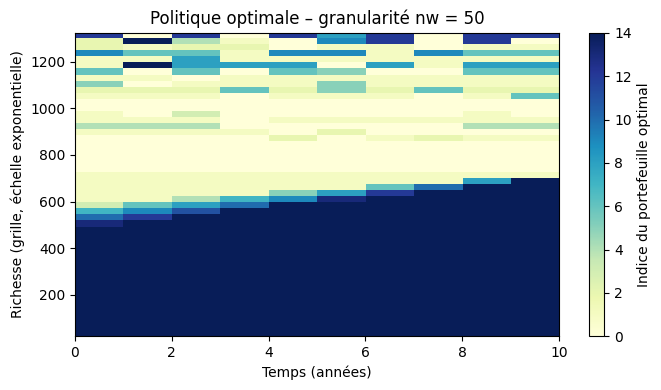

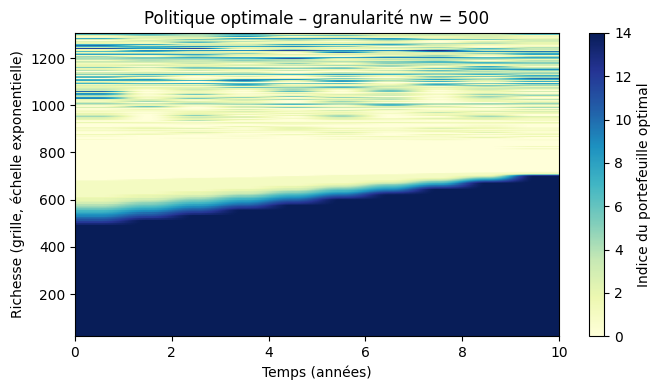


=== Test A – Effet de la granularité de la grille (nw) ===
    nw       wmin       wmax     P_IS    P_OOS   CI_low  CI_high  t_DP(s) t_sim(s)
    50      21.58    1324.70    0.670    0.663    0.654    0.672    0.047    0.700
   100      21.61    1326.95    0.671    0.671    0.662    0.680    0.036    0.630
   200      21.19    1300.86    0.670    0.672    0.663    0.681    0.061    0.625
   300      21.34    1310.26    0.670    0.673    0.664    0.682    0.091    0.641
   400      21.20    1301.47    0.670    0.672    0.663    0.681    0.114    0.654
   500      21.29    1306.97    0.670    0.672    0.663    0.681    0.149    0.715


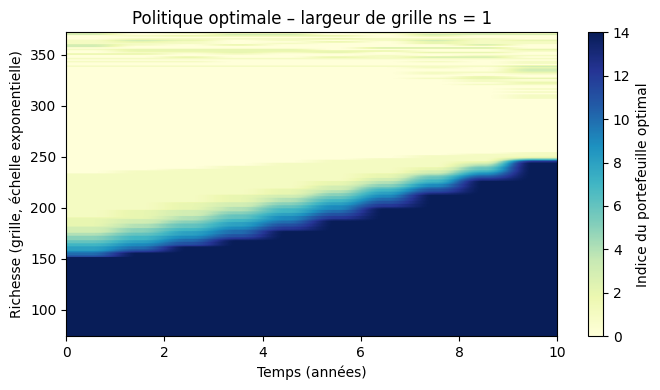

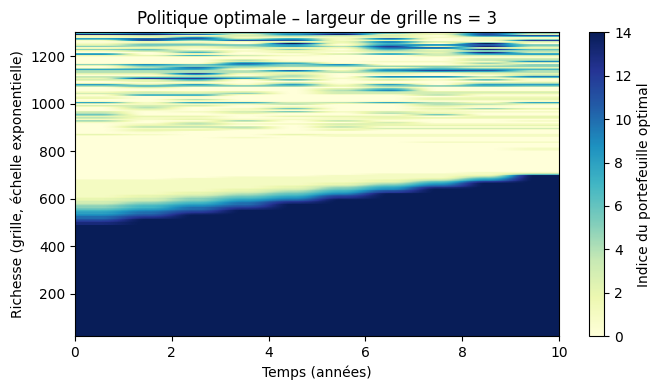

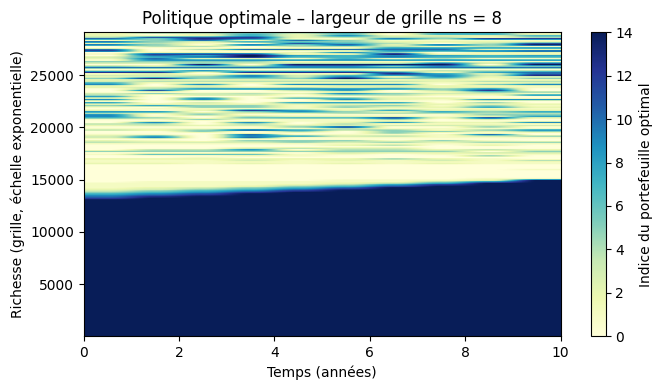


=== Test B – Effet du nombre d'écarts-types (ns) ===
  ns       wmin       wmax     P_IS    P_OOS   CI_low  CI_high  t_DP(s) t_sim(s)
   1      74.10     371.81    0.718    0.670    0.660    0.679    0.068    0.624
   2      39.59     694.87    0.670    0.673    0.664    0.682    0.065    0.644
   3      21.19    1300.86    0.670    0.672    0.663    0.681    0.049    0.687
   4      11.30    2426.52    0.670    0.671    0.662    0.680    0.049    0.632
   5       5.98    4489.70    0.670    0.671    0.662    0.680    0.043    0.641
   6       3.20    8412.33    0.671    0.671    0.662    0.681    0.060    0.616
   7       1.74   15961.74    0.672    0.671    0.661    0.680    0.051    0.627
   8       0.91   29111.23    0.672    0.670    0.661    0.679    0.051    0.644


In [178]:


# Test A : effet de la granularité de la grille de richesse (nw).
# vmu, vsi : moyennes et écarts-types des actifs de base
# mu_ports, sigma_ports : rendements et volatilités des portefeuilles efficients
# -> ils doivent être calculés avant avec ta fonction efficient_frontier_portfolios

nw_list = [50, 100, 200, 300,400, 500]

results_A = run_test_A_grid_discretization(
        w0=w0,
        G=G,
        T=T,
        vmu=vmu,
        vsi=vsi,
        mu_ports=mu_ports,
        sigma_ports=sigma_ports,
        nw_list=nw_list,
        ns=3,
        n_sims=10000,
        seed=123,
)
ns_list = [1, 2, 3, 4,5,6,7,8]

results_B = run_test_B_ns_effect(
        w0=w0,
        G=G,
        T=T,
        vmu=vmu,
        vsi=vsi,
        mu_ports=mu_ports,
        sigma_ports=sigma_ports,
        ns_list=ns_list,
        nw=200,
        n_sims=10000,
        seed=123,
    )


In [179]:

# 7) Test hors-échantillon (MC)

n_sims = 20000
W_T_all, prob_oos = simulate_out_of_sample(
    w0, G, w_grid, mu_ports, sigma_ports, policy, T,
    n_sims=n_sims, seed=123
)

print(f"Probabilité hors-échantillon (MC, n={n_sims}) d'avoir au moins {G} à T={T} : {prob_oos:.7f}")


Probabilité hors-échantillon (MC, n=20000) d'avoir au moins 200.0 à T=10 : 0.6716500
